## Table of Contents

* [Chapter 1](#chapter1): Data Preparation
* [Chapter 2](#chapter2): ML Algorithms with Count / TF-IDF Vectorized Statements
    * [Section 2.1](#section_2_1): Vectorizing
    * [Section 2.2](#section_2_2): Logistic Regression
    * [Section 2.3](#section_2_3): XGBoost
    * [Section 2.4](#section_2_4): Random Forest
* [Chapter 3](#chapter3): ML Algorithms with Embedded Statements
    * [Section 3.1](#section_3_1): Embeddings
    * [Section 3.2](#section_3_2): Logistic Regression
    * [Section 3.3](#section_3_3): XGBoost
    * [Section 3.4](#section_3_4): Random Forest
* [Chapter 4](#chapter4): Ensemble Method
* [Chapter 5](#chapter5): Propagation

## Chapter 1: <a class="anchor" id="chapter1"></a> Data Preparation

In [1]:
#Performing required installations
#pip install xgboost
#pip install spacy
#pip install fasttext

#fasttext.util.download_model("de", if_exists = "ignore") 

In [2]:
#Importing libraries
#Data processing
import pandas as pd
import numpy as np

#Vectorizing and embedding
import fasttext
import fasttext.util
import spacy

#Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xg
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

#Other
import warnings
import os
import pickle
from tqdm import tqdm
tqdm.pandas()

In [3]:
#Suppressing warnings
warnings.simplefilter(action = "ignore")

In [4]:
#Reading in CSVs
os.chdir("..")
os.chdir("..")
df = pd.read_csv("Outputs/Articles/Snorkel/snorkel.csv", index_col = 0, parse_dates = ["pubtime", "pubday", "pubmonth"])
os.chdir("Notebooks/Articles")

In [5]:
#Dropping duplicates
df_unique = df.drop_duplicates(subset = ["sentence_ABSA", "entity_name"])

In [6]:
#Setting X and y
X = df_unique[["clause_ABSA", "entity_name"]]
y = df_unique[["sentiment", "manual_annotation"]]

In [7]:
#Setting problem to negative sentiment classification only
y["sentiment"] = y["sentiment"].apply(lambda x: 0 if x == 1 else x)

In [8]:
#Mapping negative sentiment to 1 instead of -1
y["sentiment"] = y["sentiment"].apply(lambda x: 1 if x == -1 else x)

In [9]:
#Splitting manual annotations between training and testing set
X_train_total_manual, X_test_manual, y_train_total_manual, y_test_manual = train_test_split(X[y["manual_annotation"] == 1], 
                                                                                            y[y["manual_annotation"] == 1], 
                                                                                            test_size = 0.5, 
                                                                                            random_state = 1)

In [10]:
#Splitting Snorkel annotations between training and testing set
X_train_total, X_test, y_train_total, y_test = train_test_split(X[y["manual_annotation"] != 1], 
                                                                y[y["manual_annotation"] != 1], 
                                                                test_size = 0.2, 
                                                                random_state = 1)

In [11]:
#Merging datasets
X_train_total = pd.concat([X_train_total, X_train_total_manual])
X_test = pd.concat([X_test, X_test_manual])
y_train_total = pd.concat([y_train_total, y_train_total_manual])
y_test = pd.concat([y_test, y_test_manual])

In [12]:
#Splitting merged datasets between training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(X_train_total, 
                                                    y_train_total, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [13]:
#Extracting gold label test set
X_test_gold = X_test[y_test["manual_annotation"] == 1]
y_test_gold = y_test[y_test["manual_annotation"] == 1]

## Chapter 2: <a class="anchor" id="chapter2"></a> ML Algorithms with Count / TF-IDF Vectorized Statements

### Section 2.1: <a class="anchor" id="section_2_1"></a> Vectorizing

In [14]:
#Instantiating and fitting CountVectorizer
cv = CountVectorizer()
cv.fit(X_train["clause_ABSA"])
X_train_total_cv = cv.transform(X_train_total["clause_ABSA"])
X_train_cv = cv.transform(X_train["clause_ABSA"])
X_vali_cv = cv.transform(X_vali["clause_ABSA"])
X_test_cv = cv.transform(X_test["clause_ABSA"])
X_test_gold_cv = cv.transform(X_test_gold["clause_ABSA"])
    
#Saving fitted CountVectorizer
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "cv.pkl"
with open(model_name, "wb") as file:
    pickle.dump(cv, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

In [15]:
#Instantiating and fitting TF-IDF
tf = TfidfVectorizer()
tf.fit(X_train["clause_ABSA"])
X_train_total_tf = tf.transform(X_train_total["clause_ABSA"])
X_train_tf = tf.transform(X_train["clause_ABSA"])
X_vali_tf = tf.transform(X_vali["clause_ABSA"])
X_test_tf = tf.transform(X_test["clause_ABSA"])
X_test_gold_tf = tf.transform(X_test_gold["clause_ABSA"])
    
#Saving fitted TF-IDF
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "tfidf.pkl"
with open(model_name, "wb") as file:
    pickle.dump(cv, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

### Section 2.2: <a class="anchor" id="section_2_2"></a> Logistic Regression

In [16]:
#Fitting logistic regression with count vectorized X
log_reg = LogisticRegression(random_state = 1)
log_reg.fit(X_train_total_cv, y_train_total["sentiment"])

LogisticRegression(random_state=1)

In [17]:
#Evaluating logistic regression with count vectorized X
y_test_cv_pred = log_reg.predict(X_test_cv)
print(classification_report(y_test["sentiment"], y_test_cv_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     30212
           1       0.78      0.55      0.65      3310

    accuracy                           0.94     33522
   macro avg       0.87      0.77      0.81     33522
weighted avg       0.94      0.94      0.94     33522



In [18]:
#Fitting logistic regression with TF-IDF vectorized X
log_reg = LogisticRegression(random_state = 1)
log_reg.fit(X_train_total_tf, y_train_total["sentiment"])

LogisticRegression(random_state=1)

In [19]:
#Evaluating logistic regression with TF-IDF vectorized X
y_test_tf_pred = log_reg.predict(X_test_tf)
print(classification_report(y_test["sentiment"], y_test_tf_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     30212
           1       0.79      0.37      0.51      3310

    accuracy                           0.93     33522
   macro avg       0.86      0.68      0.73     33522
weighted avg       0.92      0.93      0.92     33522



In [20]:
#Deriving best parameters for logistic regression
log_reg_params = [{"penalty": ["l1", "l2", "elasticnet", "none"]}]
gs = GridSearchCV(LogisticRegression(solver = "liblinear"), 
                  param_grid = log_reg_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_penalty = gs.best_params_
best_params_penalty

{'penalty': 'l1'}

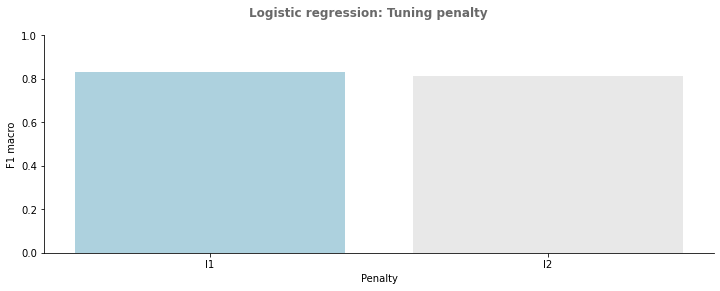

In [21]:
#Visualizing hyperparameter tuning
#Preparing data
y = gs.cv_results_["mean_test_score"][gs.cv_results_["mean_test_score"] > 0]

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning penalty",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(["l1", "l2"], y, color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Penalty")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [22]:
#Deriving best parameters for logistic regression
log_reg_params = [{"C": np.linspace(1, 100, 10)}]
gs = GridSearchCV(LogisticRegression(solver = "liblinear",
                                     penalty = best_params_penalty["penalty"]), 
                  param_grid = log_reg_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_C = gs.best_params_
best_params_C

{'C': 12.0}

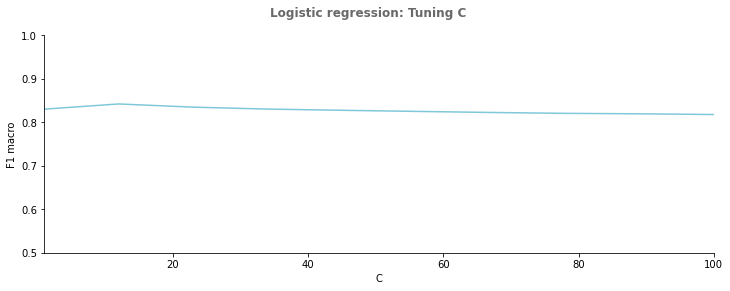

In [23]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning C",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(1, 100, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("C")
plt.xlim(1, 100)

plt.show()

In [24]:
#Fitting logistic regression
log_reg_cv = LogisticRegression(solver = "liblinear",
                                penalty = best_params_penalty["penalty"],
                                C = best_params_C["C"], 
                                random_state = 1)
log_reg_cv.fit(X_train_total_cv, y_train_total["sentiment"])

LogisticRegression(C=12.0, penalty='l1', random_state=1, solver='liblinear')

In [25]:
#Evaluating logistic regression on total test set
y_test_cv_pred = log_reg_cv.predict(X_test_cv)
print(classification_report(y_test["sentiment"], y_test_cv_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     30212
           1       0.72      0.67      0.69      3310

    accuracy                           0.94     33522
   macro avg       0.84      0.82      0.83     33522
weighted avg       0.94      0.94      0.94     33522



In [26]:
#Evaluating logistic regression on gold test set
y_test_gold_cv_pred = log_reg_cv.predict(X_test_gold_cv)
print(classification_report(y_test_gold["sentiment"], y_test_gold_cv_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2123
           1       0.40      0.31      0.35       282

    accuracy                           0.87      2405
   macro avg       0.66      0.62      0.64      2405
weighted avg       0.85      0.87      0.86      2405



In [27]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "log_reg_cv.pkl"
with open(model_name, "wb") as file:
    pickle.dump(log_reg_cv, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

### Section 2.3: <a class="anchor" id="section_2_3"></a> XGBoost

In [28]:
#Fitting XGBoost with count vectorized X
xgbr = xg.XGBClassifier(random_state = 1)
xgbr.fit(X_train_total_cv, y_train_total["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [29]:
#Evaluating XGBoost with count vectorized X
y_test_cv_pred = xgbr.predict(X_test_cv)
print(classification_report(y_test["sentiment"], y_test_cv_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     30212
           1       0.71      0.37      0.48      3310

    accuracy                           0.92     33522
   macro avg       0.82      0.67      0.72     33522
weighted avg       0.91      0.92      0.91     33522



In [30]:
#Fitting XGBoost with TF-IDF vectorized X
xgbr = xg.XGBClassifier(random_state = 1)
xgbr.fit(X_train_total_tf, y_train_total["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [31]:
#Evaluating XGBoost with TF-IDF vectorized X
y_test_tf_pred = xgbr.predict(X_test_tf)
print(classification_report(y_test["sentiment"], y_test_tf_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     30212
           1       0.72      0.37      0.49      3310

    accuracy                           0.92     33522
   macro avg       0.83      0.68      0.72     33522
weighted avg       0.91      0.92      0.91     33522



In [32]:
#Deriving best parameters for XGBoost
xgbr_params = [{"booster": ["gbtree", "gblinear", "dart"]}]
gs = GridSearchCV(xg.XGBClassifier(), 
                  param_grid = xgbr_params,
                  cv = 5, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_booster = gs.best_params_
best_params_booster

{'booster': 'gblinear'}

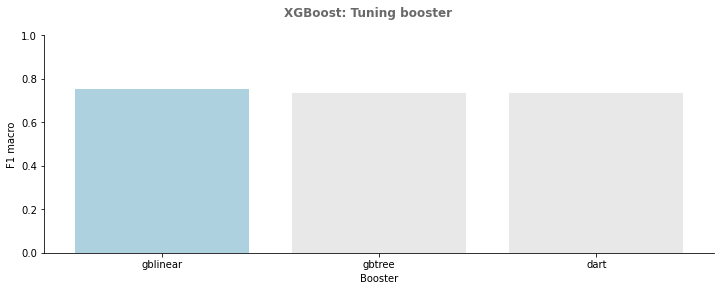

In [33]:
#Visualizing hyperparameter tuning
#Preparing data
gs_results = pd.DataFrame(data = {"f1_macro": abs(gs.cv_results_["mean_test_score"]), 
                                  "booster": ["gbtree", "gblinear", "dart"]})
gs_results.sort_values("f1_macro", ascending = False, inplace = True)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning booster",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(gs_results["booster"], gs_results["f1_macro"], color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Booster")

#Setting parameters
ax.patches[0].set_facecolor("#add1de")

plt.show()

In [34]:
#Deriving best parameters for XGBoost
xgbr_params = [{"learning_rate": np.linspace(0.5, 3, num = 5)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree"), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_learning_rate = gs.best_params_
best_params_learning_rate

{'learning_rate': 1.125}

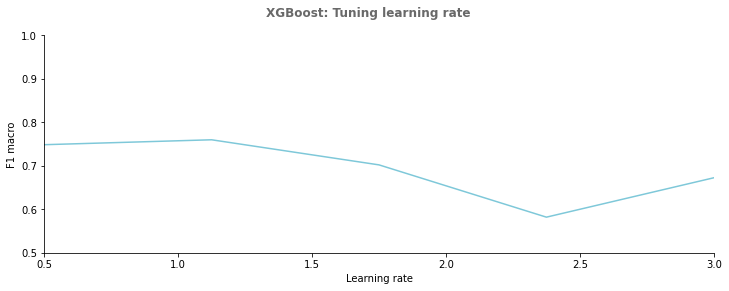

In [35]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning learning rate",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 3, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Learning rate")
plt.xlim(0.5, 3)

plt.show()

In [36]:
#Deriving best parameters for XGBoost
xgbr_params = [{"max_depth": [8,9,10,11,12]}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"], 
                                   learning_rate = best_params_learning_rate["learning_rate"]), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_max_depth = gs.best_params_
best_params_max_depth

{'max_depth': 12}

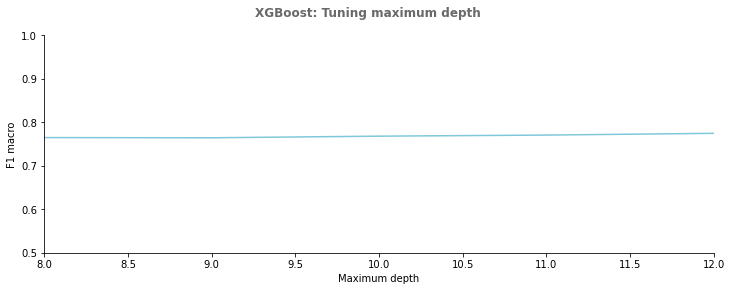

In [37]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning maximum depth",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([8,9,10,11,12], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Maximum depth")
plt.xlim(8, 12)

plt.show()

In [38]:
#Deriving best parameters for XGBoost
xgbr_params = [{"subsample": np.linspace(0.5, 1, num = 5)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"]), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_subsample = gs.best_params_
best_params_subsample

{'subsample': 1.0}

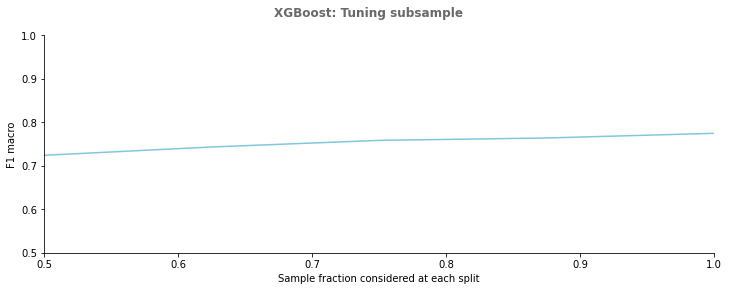

In [39]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning subsample",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Sample fraction considered at each split")
plt.xlim(0.5, 1.0)

plt.show()

In [40]:
#Deriving best parameters for XGBoost
xgbr_params = [{"colsample_bytree": np.linspace(0.5, 1, num = 5)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"]), 
                  param_grid = xgbr_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_colsample = gs.best_params_
best_params_colsample

{'colsample_bytree': 1.0}

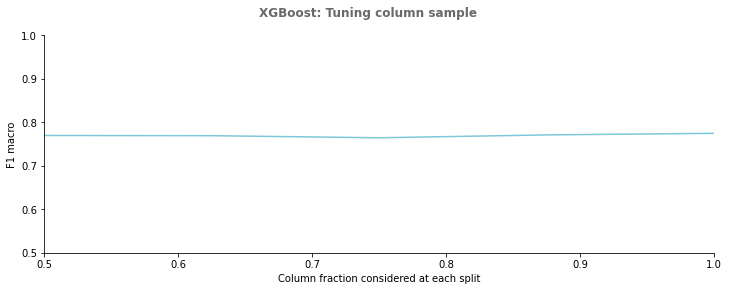

In [41]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning column sample",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.5, 1, num = 5), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Column fraction considered at each split")
plt.xlim(0.5, 1)

plt.show()

In [42]:
#Deriving hyperparameters for XGBoost
rndf_params = [{"n_estimators": [x for x in range(100, 200, 10)]}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"], 
                                   colsample_bytree = best_params_colsample["colsample_bytree"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_estimators = gs.best_params_
best_params_estimators

{'n_estimators': 190}

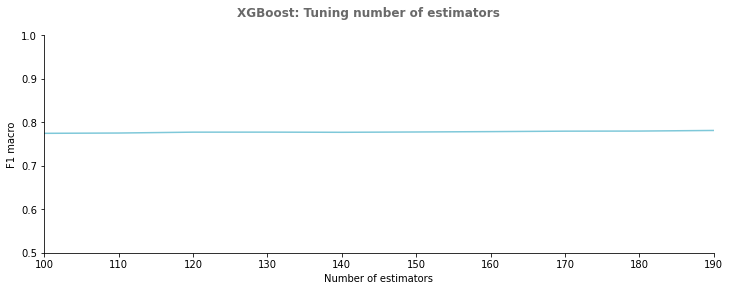

In [43]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning number of estimators",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot([x for x in range(100, 200, 10)], abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Number of estimators")
plt.xlim(100, 190)

plt.show()

In [44]:
#Deriving hyperparameters for XGBoost
rndf_params = [{"gamma": np.linspace(0.01, 0.1, 10)}]
gs = GridSearchCV(xg.XGBClassifier(booster = "gbtree",
                                   #best_params_booster["booster"],
                                   learning_rate = best_params_learning_rate["learning_rate"],
                                   max_depth = best_params_max_depth["max_depth"],
                                   subsample = best_params_subsample["subsample"], 
                                   colsample_bytree = best_params_colsample["colsample_bytree"], 
                                   n_estimators = best_params_estimators["n_estimators"]), 
                  param_grid = rndf_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_cv, y_train_total["sentiment"])
best_params_gamma = gs.best_params_
best_params_gamma

{'gamma': 0.06000000000000001}

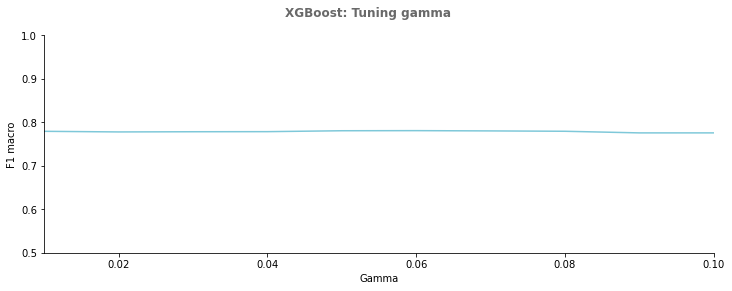

In [45]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("XGBoost: Tuning gamma",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(0.01, 0.1, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("Gamma")
plt.xlim(0.01, 0.1)

plt.show()

In [46]:
#Fitting XGBoost
xgb_cv = xg.XGBClassifier(objective = "binary:logistic", 
                          booster = "gbtree",
                          #best_params_booster["booster"],
                          learning_rate = best_params_learning_rate["learning_rate"],
                          max_depth = int(best_params_max_depth["max_depth"]),
                          subsample = best_params_subsample["subsample"],
                          colsample_bytree = best_params_colsample["colsample_bytree"], 
                          n_estimators = best_params_estimators["n_estimators"],
                          gamma = best_params_gamma["gamma"],
                          random_state = 1)
xgb_cv.fit(X_train_total_cv, y_train_total["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.06000000000000001, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=1.125, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=12, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=190, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1, reg_alpha=0, reg_lambda=1, ...)

In [47]:
#Evaluating XGBoost on total test set
y_test_cv_pred = xgb_cv.predict(X_test_cv)
print(classification_report(y_test["sentiment"], y_test_cv_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     30212
           1       0.69      0.57      0.62      3310

    accuracy                           0.93     33522
   macro avg       0.82      0.77      0.79     33522
weighted avg       0.93      0.93      0.93     33522



In [48]:
#Evaluating XGBoost on gold test set
y_test_gold_cv_pred = xgb_cv.predict(X_test_gold_cv)
print(classification_report(y_test_gold["sentiment"], y_test_gold_cv_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2123
           1       0.38      0.26      0.31       282

    accuracy                           0.86      2405
   macro avg       0.64      0.60      0.62      2405
weighted avg       0.84      0.86      0.85      2405



In [49]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "xgb_cv.pkl"
with open(model_name, "wb") as file:
    pickle.dump(xgb_cv, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

### Section 2.4: <a class="anchor" id="section_2_4"></a> Random Forest

In [50]:
#Fitting random forest with count vectorized X
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train_total_cv, y_train_total["sentiment"])

RandomForestClassifier(random_state=1)

In [51]:
#Evaluating random forest with count vectorized X
y_test_cv_pred = rf.predict(X_test_cv)
print(classification_report(y_test["sentiment"], y_test_cv_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     30212
           1       0.76      0.47      0.58      3310

    accuracy                           0.93     33522
   macro avg       0.85      0.73      0.77     33522
weighted avg       0.93      0.93      0.93     33522



In [52]:
#Fitting random forest with TF-IDF vectorized X
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train_total_tf, y_train_total["sentiment"])

RandomForestClassifier(random_state=1)

In [53]:
#Evaluating random forest with TF-IDF vectorized X
y_test_tf_pred = rf.predict(X_test_tf)
print(classification_report(y_test["sentiment"], y_test_tf_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     30212
           1       0.77      0.43      0.56      3310

    accuracy                           0.93     33522
   macro avg       0.86      0.71      0.76     33522
weighted avg       0.92      0.93      0.92     33522



In [54]:
#Fitting random forest
#No GridSearch given long training time
rf_cv = RandomForestClassifier(max_features = 3000, 
                               max_depth = 2500,
                               random_state = 1)
rf_cv.fit(X_train_total_cv, y_train_total["sentiment"])

RandomForestClassifier(max_depth=2500, max_features=3000, random_state=1)

In [55]:
#Evaluating random forest on total test set
y_test_cv_pred = rf_cv.predict(X_test_cv)
print(classification_report(y_test["sentiment"], y_test_cv_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     30212
           1       0.70      0.57      0.63      3310

    accuracy                           0.93     33522
   macro avg       0.83      0.77      0.80     33522
weighted avg       0.93      0.93      0.93     33522



In [56]:
#Evaluating random forest on gold test set
y_test_gold_cv_pred = rf_cv.predict(X_test_gold_cv)
print(classification_report(y_test_gold["sentiment"], y_test_gold_cv_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2123
           1       0.46      0.31      0.37       282

    accuracy                           0.88      2405
   macro avg       0.69      0.63      0.65      2405
weighted avg       0.86      0.88      0.87      2405



In [57]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "rf_cv.pkl"
with open(model_name, "wb") as file:
    pickle.dump(rf_cv, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

## Chapter 3: <a class="anchor" id="chapter3"></a> ML Algorithms with Embedded Statements

### Section 3.1: <a class="anchor" id="section_3_1"></a> Embeddings

In [58]:
#Loading fastText embeddings
ft = fasttext.load_model("Resources/fastText/cc.de.300.bin")

In [59]:
#Defining function to return fastText vectors
def get_ft_vectors(tokens, dimension):
    tokens = [token_split for token in tokens for token_split in token.split("_")]
    dim_y = len(tokens)
    dim_x = dimension
    vectors = np.empty((dim_y, dim_x))
    for index, token in enumerate(tokens):
        try:
            vectors[index] = ft.get_word_vector(token)
        except:
            vectors[index] = 0 
    return vectors

In [60]:
#Loading GloVe embeddings
os.chdir("..")
os.chdir("..")
df_glove = pd.read_csv("Resources/GloVe/Vectors.txt", sep = " ", header = None)
os.chdir("Notebooks/Articles")

In [61]:
#Defining function to return GloVe vectors
def get_glove_vectors(tokens, dimension):
    tokens = [token_split for token in tokens for token_split in token.split("_")]
    dim_y = len(tokens)
    dim_x = dimension
    vectors = np.empty((dim_y, dim_x))
    for index, token in enumerate(tokens):
        try:
            df_filtered = df_glove[df_glove[0] == token]
            vector = np.array(df_filtered.iloc[0,1:dimension+1])
            vectors[index] = vector
        except:
            vectors[index] = 0
    return vectors

In [62]:
#Loading Word2Vec embeddings
os.chdir("..")
os.chdir("..")
df_word2vec = pd.read_csv("Resources/Word2Vec/Vectors.txt", sep = " ", header = None)
os.chdir("Notebooks/Articles")

In [63]:
#Cleaning text
df_word2vec[0] = df_word2vec[0].apply(lambda x: x.replace("b'", "").replace("'", ""))

In [64]:
#Defining function to return Word2Vec vectors
def get_word2vec_vectors(tokens, dimension):
    tokens = [token_split for token in tokens for token_split in token.split("_")]
    dim_y = len(tokens)
    dim_x = dimension
    vectors = np.empty((dim_y, dim_x))
    for index, token in enumerate(tokens):
        try:
            df_filtered = df_word2vec[df_word2vec[0] == token]
            vector = np.array(df_filtered.iloc[0,1:dimension+1])
            vectors[index] = vector
        except:
            vectors[index] = 0
    return vectors

In [65]:
#Instantiating nlp
nlp = spacy.load("de_core_news_md", disable = ["tagger", "parser", "ner"])

In [66]:
#Defining function to return Spacy vectors
def get_spacy_vectors(tokens):
    tokens = [token_split for token in tokens for token_split in token.split("_")]
    tokens_string = " ".join(tokens)
    doc = nlp(tokens_string)
    dim_y = len(doc)
    dim_x = 300
    vectors = np.empty((dim_y, dim_x))
    for index, token in enumerate(doc):
        try:
            vector = token.vector
            vectors[index] = vector
        except:
            vectors[index] = 0
    return vectors

In [67]:
#Creating embedding dataframes
X_train_total_embed = X_train_total.copy()
X_train_embed = X_train.copy()
X_vali_embed = X_vali.copy()
X_test_embed = X_test.copy()
X_test_gold_embed = X_test_gold.copy()

In [68]:
#Generating tokens
X_train_total_embed["clause_ABSA_tokens"] = X_train_total_embed["clause_ABSA"].apply(lambda x: x.split(" "))
X_train_embed["clause_ABSA_tokens"] = X_train_embed["clause_ABSA"].apply(lambda x: x.split(" "))
X_vali_embed["clause_ABSA_tokens"] = X_vali_embed["clause_ABSA"].apply(lambda x: x.split(" "))
X_test_embed["clause_ABSA_tokens"] = X_test_embed["clause_ABSA"].apply(lambda x: x.split(" "))
X_test_gold_embed["clause_ABSA_tokens"] = X_test_gold_embed["clause_ABSA"].apply(lambda x: x.split(" "))

In [69]:
#Getting fastText vectors
X_train_total_embed["clause_ABSA_ft_vectors"] = X_train_total_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_ft_vectors(x, 300).mean(axis = 0))
X_train_embed["clause_ABSA_ft_vectors"] = X_train_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_ft_vectors(x, 300).mean(axis = 0))
X_vali_embed["clause_ABSA_ft_vectors"] = X_vali_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_ft_vectors(x, 300).mean(axis = 0))
X_test_embed["clause_ABSA_ft_vectors"] = X_test_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_ft_vectors(x, 300).mean(axis = 0))
X_test_gold_embed["clause_ABSA_ft_vectors"] = X_test_gold_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_ft_vectors(x, 300).mean(axis = 0))

100%|█████████████████████████████████████| 2405/2405 [00:00<00:00, 8302.73it/s]


In [70]:
#Getting GloVe vectors - takes too long
#X_train_total_embed["clause_ABSA_glove_vectors"] = X_train_total_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_glove_vectors(x, 300).mean(axis = 0))
#X_train_embed["clause_ABSA_glove_vectors"] = X_train_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_glove_vectors(x, 300).mean(axis = 0))
#X_vali_embed["clause_ABSA_glove_vectors"] = X_vali_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_glove_vectors(x, 300).mean(axis = 0))
#X_test_embed["clause_ABSA_glove_vectors"] = X_test_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_glove_vectors(x, 300).mean(axis = 0))
#X_test_gold_embed["clause_ABSA_glove_vectors"] = X_test_gold_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_glove_vectors(x, 300).mean(axis = 0))

In [71]:
#Getting Word2Vec vectors - takes too long
#X_train_total_embed["clause_ABSA_word2vec_vectors"] = X_train_total_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_word2vec_vectors(x, 300).mean(axis = 0))
#X_train_embed["clause_ABSA_word2vec_vectors"] = X_train_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_word2vec_vectors(x, 300).mean(axis = 0))
#X_vali_embed["clause_ABSA_word2vec_vectors"] = X_vali_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_word2vec_vectors(x, 300).mean(axis = 0))
#X_test_embed["clause_ABSA_word2vec_vectors"] = X_test_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_word2vec_vectors(x, 300).mean(axis = 0))
#X_test_gold_embed["clause_ABSA_word2vec_vectors"] = X_test_gold_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_word2vec_vectors(x, 300).mean(axis = 0))

In [72]:
#Getting Spacy vectors
X_train_total_embed["clause_ABSA_spacy_vectors"] = X_train_total_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))
X_train_embed["clause_ABSA_spacy_vectors"] = X_train_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))
X_vali_embed["clause_ABSA_spacy_vectors"] = X_vali_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))
X_test_embed["clause_ABSA_spacy_vectors"] = X_test_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))
X_test_gold_embed["clause_ABSA_spacy_vectors"] = X_test_gold_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))

100%|██████████████████████████████████████| 2405/2405 [00:05<00:00, 464.56it/s]


### Section 3.2: <a class="anchor" id="section_3_2"></a> Logistic Regression

In [73]:
#Fitting logistic regression with fastText embeddings
log_reg = LogisticRegression(random_state = 1)
log_reg.fit(X_train_total_embed["clause_ABSA_ft_vectors"].to_list(), y_train_total["sentiment"])

LogisticRegression(random_state=1)

In [74]:
#Evaluating logistic regression with fastText embeddings
y_test_ft_pred = log_reg.predict(X_test_embed["clause_ABSA_ft_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_ft_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     30212
           1       0.67      0.13      0.22      3310

    accuracy                           0.91     33522
   macro avg       0.79      0.56      0.58     33522
weighted avg       0.89      0.91      0.88     33522



In [75]:
#Fitting logistic regression with Spacy embeddings
log_reg = LogisticRegression(random_state = 1)
log_reg.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])

LogisticRegression(random_state=1)

In [76]:
#Evaluating logistic regression with Spacy embeddings
y_test_spacy_pred = log_reg.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_spacy_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     30212
           1       0.63      0.25      0.36      3310

    accuracy                           0.91     33522
   macro avg       0.78      0.62      0.65     33522
weighted avg       0.89      0.91      0.89     33522



In [77]:
#Deriving best parameters for logistic regression
log_reg_params = [{"penalty": ["l1", "l2", "elasticnet", "none"]}]
gs = GridSearchCV(LogisticRegression(solver = "liblinear"), 
                  param_grid = log_reg_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])
best_params_penalty = gs.best_params_
best_params_penalty

{'penalty': 'l2'}

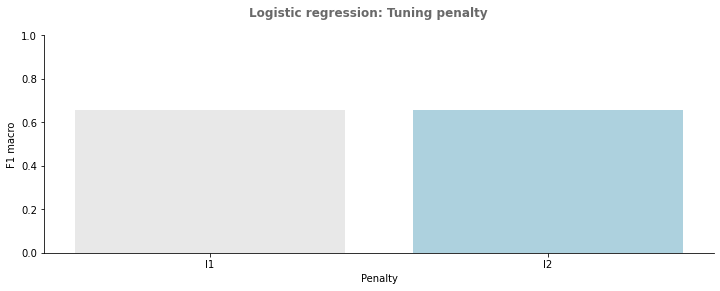

In [78]:
#Visualizing hyperparameter tuning
#Preparing data
y = gs.cv_results_["mean_test_score"][gs.cv_results_["mean_test_score"] > 0]

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning penalty",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.bar(["l1", "l2"], y, color = "#E8E8E8")
plt.ylabel("F1 macro")
plt.ylim(0, 1)
plt.xlabel("Penalty")

#Setting parameters
ax.patches[1].set_facecolor("#add1de")

plt.show()

In [79]:
#Deriving best parameters for logistic regression
log_reg_params = [{"C": np.linspace(1, 100, 10)}]
gs = GridSearchCV(LogisticRegression(solver = "liblinear",
                                     penalty = best_params_penalty["penalty"]), 
                  param_grid = log_reg_params,
                  cv = 2, 
                  scoring = "f1_macro")
gs.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])
best_params_C = gs.best_params_
best_params_C

{'C': 89.0}

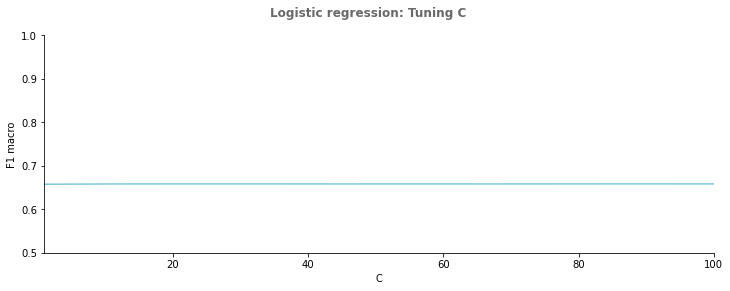

In [80]:
#Visualizing hyperparameter tuning
#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 4))
sns.despine(top = True)
fig.suptitle("Logistic regression: Tuning C",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plt.plot(np.linspace(1, 100, 10), abs(gs.cv_results_["mean_test_score"]), color = "#7ec8d9")
plt.ylabel("F1 macro")
plt.ylim(0.5, 1)
plt.xlabel("C")
plt.xlim(1, 100)

plt.show()

In [81]:
#Fitting logistic regression
log_reg_spacy = LogisticRegression(solver = "liblinear",
                                   penalty = best_params_penalty["penalty"],
                                   C = best_params_C["C"], 
                                   random_state = 1)
log_reg_spacy.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])

LogisticRegression(C=89.0, random_state=1, solver='liblinear')

In [82]:
#Evaluating logistic regression on total test set
y_test_spacy_pred = log_reg_spacy.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_spacy_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     30212
           1       0.64      0.25      0.36      3310

    accuracy                           0.91     33522
   macro avg       0.78      0.62      0.66     33522
weighted avg       0.89      0.91      0.89     33522



In [83]:
#Evaluating logistic regression on gold test set
y_test_gold_spacy_pred = log_reg_spacy.predict(X_test_gold_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test_gold["sentiment"], y_test_gold_spacy_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2123
           1       0.34      0.09      0.14       282

    accuracy                           0.87      2405
   macro avg       0.62      0.53      0.54      2405
weighted avg       0.83      0.87      0.84      2405



In [84]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "log_reg_spacy.pkl"
with open(model_name, "wb") as file:
    pickle.dump(log_reg_spacy, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

### Section 3.3: <a class="anchor" id="section_3_3"></a> XGBoost

In [85]:
#Fitting XGBoost with fastText embeddings
xgbr = xg.XGBClassifier(random_state = 1)
xgbr.fit(X_train_total_embed["clause_ABSA_ft_vectors"].to_list(), y_train_total["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [86]:
#Evaluating XGBoost with fastText embeddings
y_test_ft_pred = xgbr.predict(X_test_embed["clause_ABSA_ft_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_ft_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     30212
           1       0.67      0.23      0.35      3310

    accuracy                           0.91     33522
   macro avg       0.80      0.61      0.65     33522
weighted avg       0.90      0.91      0.89     33522



In [87]:
#Fitting XGBoost with Spacy embeddings
xgbr = xg.XGBClassifier(random_state = 1)
xgbr.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [88]:
#Evaluating XGBoost with Spacy embeddings
y_test_spacy_pred = xgbr.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_spacy_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     30212
           1       0.65      0.22      0.33      3310

    accuracy                           0.91     33522
   macro avg       0.79      0.60      0.64     33522
weighted avg       0.89      0.91      0.89     33522



In [89]:
#Fitting XGBoost
#No GridSearch given long training time
xgb_spacy = xg.XGBClassifier(objective = "binary:logistic", 
                             booster = "gbtree",
                             #best_params_booster["booster"],
                             learning_rate = 0.8,
                             max_depth = 8,
                             subsample = 1,
                             colsample_bytree = 1, 
                             n_estimators = 200,
                             gamma = 0,
                             random_state = 1)
xgb_spacy.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.8, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [90]:
#Evaluating XGBoost on total test set
y_test_spacy_pred = xgb_spacy.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_spacy_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     30212
           1       0.65      0.31      0.42      3310

    accuracy                           0.92     33522
   macro avg       0.79      0.64      0.69     33522
weighted avg       0.90      0.92      0.90     33522



In [91]:
#Evaluating XGBoost on gold test set
y_test_gold_spacy_pred = xgb_spacy.predict(X_test_gold_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test_gold["sentiment"], y_test_gold_spacy_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2123
           1       0.49      0.22      0.30       282

    accuracy                           0.88      2405
   macro avg       0.70      0.59      0.62      2405
weighted avg       0.86      0.88      0.86      2405



In [92]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "xgb_spacy.pkl"
with open(model_name, "wb") as file:
    pickle.dump(xgb_spacy, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

### Section 3.4: <a class="anchor" id="section_3_4"></a> Random Forest

In [93]:
#Fitting random forest with fastText embeddings
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train_total_embed["clause_ABSA_ft_vectors"].to_list(), y_train_total["sentiment"])

RandomForestClassifier(random_state=1)

In [94]:
#Evaluating random forest with fastText embeddings
y_test_ft_pred = rf.predict(X_test_embed["clause_ABSA_ft_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_ft_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     30212
           1       0.85      0.11      0.20      3310

    accuracy                           0.91     33522
   macro avg       0.88      0.55      0.57     33522
weighted avg       0.91      0.91      0.88     33522



In [95]:
#Fitting random forest with Spacy embeddings
rf = RandomForestClassifier(random_state = 1)
rf.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])

RandomForestClassifier(random_state=1)

In [96]:
#Evaluating random forest with Spacy embeddings
y_test_spacy_pred = rf.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_spacy_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     30212
           1       0.84      0.10      0.18      3310

    accuracy                           0.91     33522
   macro avg       0.87      0.55      0.56     33522
weighted avg       0.90      0.91      0.88     33522



In [97]:
#Fitting random forest
#No GridSearch given long training time
rf_spacy = RandomForestClassifier(#max_features = 3000, 
                                  #max_depth = 2500,
                                  random_state = 1)
rf_spacy.fit(X_train_total_embed["clause_ABSA_spacy_vectors"].to_list(), y_train_total["sentiment"])

RandomForestClassifier(random_state=1)

In [98]:
#Evaluating random forest on total test set
y_test_spacy_pred = rf_spacy.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test["sentiment"], y_test_spacy_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     30212
           1       0.84      0.10      0.18      3310

    accuracy                           0.91     33522
   macro avg       0.87      0.55      0.56     33522
weighted avg       0.90      0.91      0.88     33522



In [99]:
#Evaluating random forest on gold test set
y_test_gold_spacy_pred = rf_spacy.predict(X_test_gold_embed["clause_ABSA_spacy_vectors"].to_list())
print(classification_report(y_test_gold["sentiment"], y_test_gold_spacy_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2123
           1       0.56      0.08      0.14       282

    accuracy                           0.88      2405
   macro avg       0.73      0.54      0.54      2405
weighted avg       0.85      0.88      0.84      2405



In [100]:
#Saving fitted model
os.chdir("..")
os.chdir("..")
os.chdir("Models/Articles/ML_DL")
model_name = "rf_spacy.pkl"
with open(model_name, "wb") as file:
    pickle.dump(rf_spacy, file)
os.chdir("..")
os.chdir("..")
os.chdir("Notebooks/Articles")

## Chapter 4: <a class="anchor" id="chapter4"></a> Ensemble Method

In [101]:
#Defining function to generate majority vote
def get_majority_vote(pred_list):
    total_votes = len(pred_list)
    total_pos = sum(pred_list)
    if total_pos >= total_votes/2:
        return 1
    else:
        return 0

In [102]:
#Generating predictions
y_test_pred_log_reg_cv = list(log_reg_cv.predict(X_test_cv))
y_test_pred_xgb_cv = list(xgb_cv.predict(X_test_cv))
y_test_pred_rf_cv = list(rf_cv.predict(X_test_cv))
y_test_pred_log_reg_spacy = list(log_reg_spacy.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list()))
y_test_pred_xgb_spacy = list(xgb_spacy.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list()))
y_test_pred_rf_spacy = list(rf_spacy.predict(X_test_embed["clause_ABSA_spacy_vectors"].to_list()))

y_test_gold_pred_log_reg_cv = list(log_reg_cv.predict(X_test_gold_cv))
y_test_gold_pred_xgb_cv = list(xgb_cv.predict(X_test_gold_cv))
y_test_gold_pred_rf_cv = list(rf_cv.predict(X_test_gold_cv))
y_test_gold_pred_log_reg_spacy = list(log_reg_spacy.predict(X_test_gold_embed["clause_ABSA_spacy_vectors"].to_list()))
y_test_gold_pred_xgb_spacy = list(xgb_spacy.predict(X_test_gold_embed["clause_ABSA_spacy_vectors"].to_list()))
y_test_gold_pred_rf_spacy = list(rf_spacy.predict(X_test_gold_embed["clause_ABSA_spacy_vectors"].to_list()))

In [103]:
#Creating dataframe
pred_df = pd.DataFrame(data = {"log_reg_cv": y_test_pred_log_reg_cv,
                               #"xgb_cv": y_test_pred_xgb_cv, 
                               "rf_cv": y_test_pred_rf_cv,
                               "log_reg_spacy": y_test_pred_log_reg_spacy, 
                               "xgb_spacy": y_test_pred_xgb_spacy, 
                               "rf_spacy": y_test_pred_rf_spacy})
pred_df["majority_vote"] = pred_df.apply(lambda x: get_majority_vote(list(x["log_reg_cv":"rf_spacy"])), axis = 1)

pred_df_gold = pd.DataFrame(data = {"log_reg_gold_cv": y_test_gold_pred_log_reg_cv,
                                    #"xgb_gold_cv": y_test_gold_pred_xgb_cv, 
                                    "rf_gold_cv": y_test_gold_pred_rf_cv,
                                    "log_reg_gold_spacy": y_test_gold_pred_log_reg_spacy, 
                                    "xgb_gold_spacy": y_test_gold_pred_xgb_spacy, 
                                    "rf_gold_spacy": y_test_gold_pred_rf_spacy
                                   })
pred_df_gold["majority_vote_gold"] = pred_df_gold.apply(lambda x: get_majority_vote(list(x["log_reg_gold_cv":"rf_gold_spacy"])), axis = 1)

In [104]:
#Evaluating ensemble on total test set
print(classification_report(y_test["sentiment"], pred_df["majority_vote"]))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     30212
           1       0.85      0.33      0.47      3310

    accuracy                           0.93     33522
   macro avg       0.89      0.66      0.72     33522
weighted avg       0.92      0.93      0.91     33522



In [105]:
#Evaluating ensemble on gold test set
print(classification_report(y_test_gold["sentiment"], pred_df_gold["majority_vote_gold"]))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      2123
           1       0.49      0.19      0.27       282

    accuracy                           0.88      2405
   macro avg       0.69      0.58      0.60      2405
weighted avg       0.85      0.88      0.86      2405



## Chapter 5: <a class="anchor" id="chapter5"></a> Propagation

In [106]:
#Count vectorizing X
X_cv = cv.transform(X["clause_ABSA"])

In [107]:
#Embedding X
X_embed = X.copy()
X_embed["clause_ABSA_tokens"] = X_embed["clause_ABSA"].apply(lambda x: x.split(" "))
X_embed["clause_ABSA_spacy_vectors"] = X_embed["clause_ABSA_tokens"].progress_apply(lambda x: get_spacy_vectors(x).mean(axis = 0))

100%|██████████████████████████████████| 160393/160393 [05:41<00:00, 470.27it/s]


In [108]:
#Generating predictions
y_pred_log_reg_cv = list(log_reg_cv.predict(X_cv))
y_pred_rf_cv = list(rf_cv.predict(X_cv))
y_pred_log_reg_spacy = list(log_reg_spacy.predict(X_embed["clause_ABSA_spacy_vectors"].to_list()))
y_pred_xgb_spacy = list(xgb_spacy.predict(X_embed["clause_ABSA_spacy_vectors"].to_list()))
y_pred_rf_spacy = list(rf_spacy.predict(X_embed["clause_ABSA_spacy_vectors"].to_list()))

In [109]:
#Creating dataframe
pred_df = pd.DataFrame(data = {"log_reg_cv": y_pred_log_reg_cv,
                               "rf_cv": y_pred_rf_cv,
                               "log_reg_spacy": y_pred_log_reg_spacy, 
                               "xgb_spacy": y_pred_xgb_spacy, 
                               "rf_spacy": y_pred_rf_spacy})
pred_df["majority_vote"] = pred_df.apply(lambda x: get_majority_vote(list(x["log_reg_cv":"rf_spacy"])), axis = 1)

In [110]:
#Joining dataframe
final_df = df_unique.join(pred_df["majority_vote"])

In [111]:
#Renaming columns
final_df.rename(columns = {"sentiment": "snorkel_sentiment", 
                           "majority_vote": "sentiment"}, 
                inplace = True)

In [112]:
#Dropping columns
final_df.drop(["index", "stratification", "sentence_ABSA_subclause", "sentence_ABSA_rel_keywords", "entity_keyword"], 
              axis = 1, 
              inplace = True)

In [114]:
#Saving to CSV
os.chdir("..")
os.chdir("..")
final_df.to_csv("Outputs/Articles/ML/ml.csv")
os.chdir("Notebooks/Articles")